# PREDICCIÓN DEL CONSUMO DE ENERGÍA USANDO REDES LSTM

##  Problema

Queremos desarrollar un modelo que sea capaz de aprender el patrón de comportamiento en una serie de tiempo (la demanda de Energía Eléctrica) en una región de Estados Unidos, y que posteriormente logre predecir cómo se comportará esta demanda en un futuro cercano.

![](https://drive.google.com/uc?export=view&id=1UaTeYJVVeHxA2nUX2d9tQIZJ8TiDPEAt)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping


/home/rodrigo/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


## El set de datos

El dataset proviene de una empresa distribuidora de Energía Eléctrica en Estados Unidos (PJM Interconnection LLC), y contiene el comportamiento histórico de la demanda (en MegaWatts) entre los años 2004 y 2018 para la ciudad de Dayton (Ohio). Los registros se realizaron con una periodicidad de 1 hora.

In [2]:
"""ruta = 'DAYTON_hourly_2004_2018.csv'

# Leer el set de datos
datos = pd.read_csv(ruta, index_col=0, parse_dates=True)
datos.head()"""

import pandas as pd

# Función para cargar y filtrar los datos
def cargar_datos_cluster(ruta_csv, cluster_id):
    # Leer el archivo CSV
    df = pd.read_csv(ruta_csv)
    
    # Configurar la primera columna ('Cluster') como índice
    df.set_index('Cluster', inplace=True)
    
    # Transponer el dataframe para que las fechas sean el índice
    df = df.transpose()
    
    # Filtrar los datos para el cluster específico
    cluster_data = df[cluster_id]
    
    # Resetear el índice para que las fechas sean una columna y no el índice
    cluster_data = cluster_data.reset_index()
    
    # Cambiar los nombres de las columnas
    cluster_data.columns = ['Fecha', 'Contagios']
    
    # Convertir la columna de fecha a tipo datetime para manejarlo como serie temporal
    cluster_data['Fecha'] = pd.to_datetime(cluster_data['Fecha'], format='%d-%m-%Y')
    
    # Establecer la fecha como índice
    cluster_data.set_index('Fecha', inplace=True)
    
    return cluster_data

# Ruta del archivo CSV
ruta_csv = 'clusterSemanal.csv'
# ID del cluster que el usuario quiere explorar
cluster_id = 0  # Cambia esto por un input del usuario si necesario

# Cargar los datos
datos = cargar_datos_cluster(ruta_csv, cluster_id)
datos.head()


,Contagios
Fecha,
2020-01-05,9
2020-01-12,38
2020-01-19,45
2020-01-26,37
2020-02-02,30


El set de datos tiene un total de 121,275 registros

In [3]:
datos.shape

(182, 1)

Ordenamiento cronológico

In [4]:
# Y organizar cronológicamente
datos.sort_index(inplace=True)

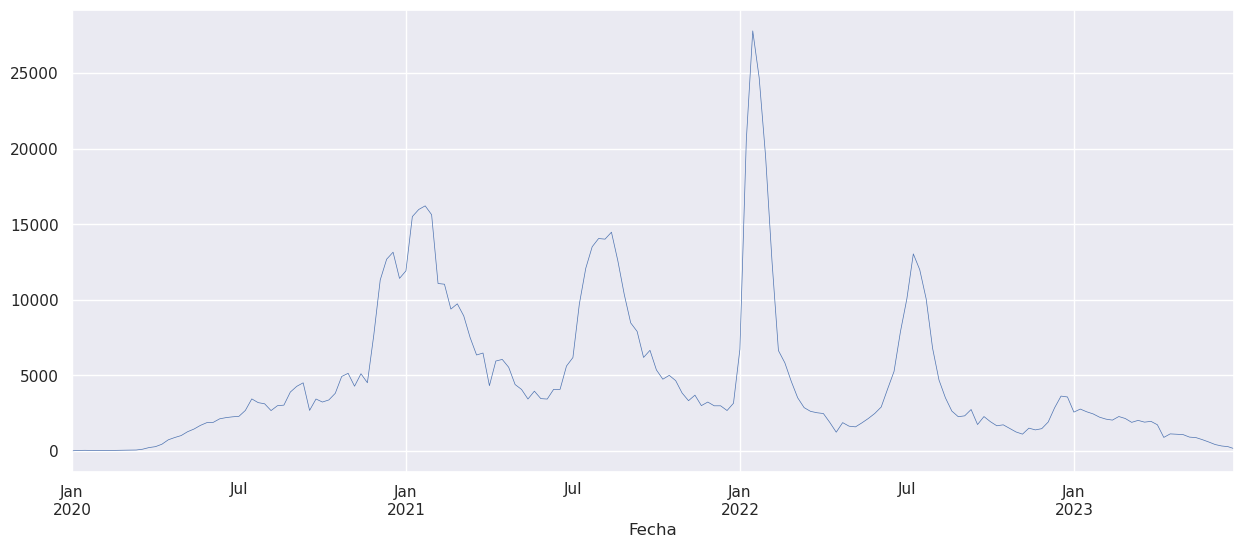

In [5]:
sns.set(rc={'figure.figsize':(15, 6)})

# Dibuja los datos de esa columna
datos['Contagios'].plot(linewidth=0.5);

## Sets de entrenamiento y prueba

Como entrada al modelo usaremos bloques de 200 datos consecutivos (`X_train`) y el modelo deberá aprender a predecir el dato 201 de la secuencia (`Y_train`):

![](https://drive.google.com/uc?export=view&id=1_VqvozHTfjVrzzJzBAII3pIendriES40)

In [6]:
def dividir_train_test(datos:pd.DataFrame, train_size)-> tuple[pd.DataFrame]:
    idx = round(len(datos)*train_size)
    return idx, datos[0:idx], datos[idx:]

In [7]:
def crear_set_traint_test(df_train:pd.DataFrame, df_test:pd.DataFrame, long_sec: int) -> tuple[pd.DataFrame]:
    X_train, Y_train = [], []
    for i in range(len(df_train)-long_sec):
        X_train.append(df_train[i:i+long_sec])
        Y_train.append(df_train[i+long_sec])

    X_test, Y_test = [], []
    for i in range(len(df_test)-long_sec):
        X_test.append(df_test[i:i+long_sec])
        Y_test.append(df_test[i+long_sec])

    X_train, Y_train = np.array(X_train), np.array(Y_train)

    # Cambiamos el tamaño a x1 por (ejemplos_train, 200, 1)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    X_test, Y_test = np.array(X_test), np.array(Y_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    return X_train, Y_train, X_test, Y_test

In [8]:
DATOS = datos['Contagios'].values
TRAIN_SIZE = 0.8

idx, datos_train, datos_test = dividir_train_test(DATOS, TRAIN_SIZE)

In [9]:
datos_train.reshape(-1,1).shape

(146, 1)

In [10]:
# Escalemos los datos entre -1 y 1 (por la tanh)
MIN, MAX = -1, 1
scaler = MinMaxScaler(feature_range=(MIN,MAX))
datos_train_s = scaler.fit_transform(datos_train.reshape(-1,1))
datos_test_s = scaler.transform(datos_test.reshape(-1,1))

Creación del set de entrenaiento y prueba

In [11]:
LONG_SEC = 14
X_train, Y_train, X_test, Y_test = crear_set_traint_test(datos_train_s, datos_test_s, LONG_SEC)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

# 108948 sets de 200 ejemplos cada uno

(132, 14, 1) (132, 1)
(22, 14, 1) (22, 1)


In [12]:
ID = 5
print(f'Ejemplo {ID}:')
print(f'   Entrada: {X_train[ID,:,:].T}')
print(f'   Salida: {Y_train[ID]}')

Ejemplo 5:
   Entrada: [[-0.99762598 -0.99805762 -0.99769792 -0.99705047 -0.99647495 -0.99604331
  -0.99215856 -0.98438905 -0.98000072 -0.96856228 -0.9474839  -0.93654904
  -0.9272688  -0.90899608]]
   Salida: [-0.89619078]


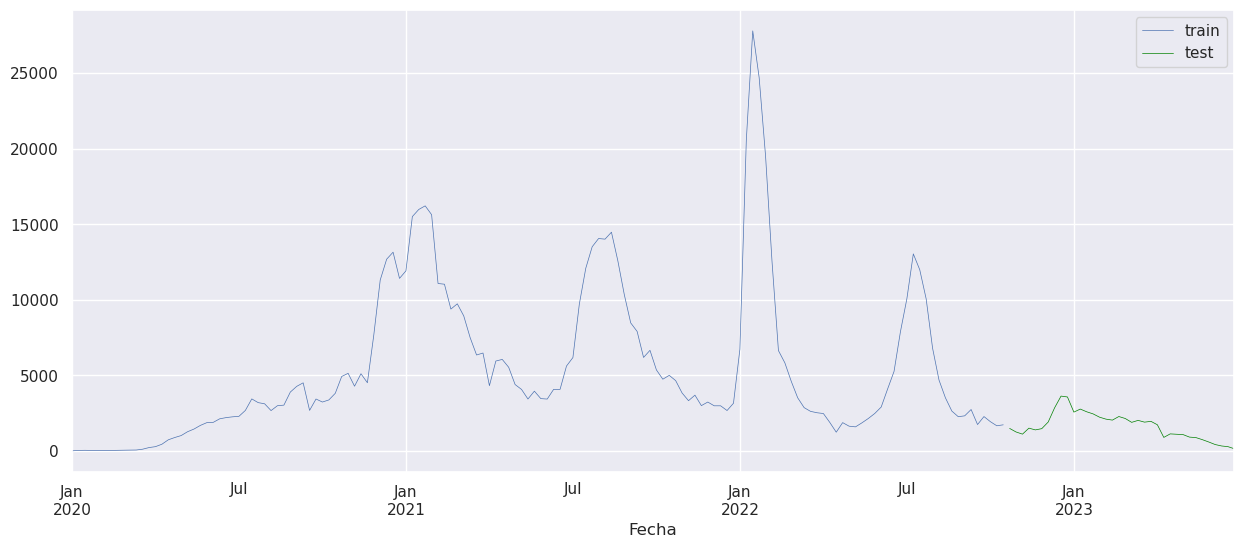

In [13]:
datos['Contagios'].iloc[0:idx].plot(linewidth=0.5, label='train')
datos['Contagios'].iloc[idx:].plot(linewidth=0.5, color='green', label='test')
plt.legend();

## 5 - Creación y entrenamiento del modelo

In [14]:
# Tamaño del estado oculto y celda de memoria (Similar al tamaño del LONG_SEC)
N_UNITS = 13
modelo = Sequential()
modelo.add(LSTM(N_UNITS, input_shape=(LONG_SEC, 1)))
modelo.add(Dense(50, activation='relu'))  # Primera capa densa adicional
modelo.add(Dropout(0.2))  # Opcional: Dropout para regularización
modelo.add(Dense(20, activation='relu'))  # Segunda capa densa adicional
modelo.add(Dense(1))  # Capa de salida

In [15]:
optimizador = RMSprop(learning_rate=0.0005)
modelo.compile(optimizer=optimizador, loss='mse', metrics='mean_absolute_error')

# Entrenamiento
EPOCHS = 200
BATCH_SIZE = 10
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

modelo.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
           validation_data=(X_test, Y_test), callbacks=[early_stopping])

Epoch 1/200


14/14 [==============================] - 2s 20ms/step - loss: 0.3851 - mean_absolute_error: 0.5671 - val_loss: 0.5757 - val_mean_absolute_error: 0.7573
Epoch 2/200
14/14 [==============================] - 0s 4ms/step - loss: 0.2846 - mean_absolute_error: 0.4859 - val_loss: 0.4198 - val_mean_absolute_error: 0.6464
Epoch 3/200
14/14 [==============================] - 0s 3ms/step - loss: 0.2116 - mean_absolute_error: 0.4188 - val_loss: 0.2558 - val_mean_absolute_error: 0.5042
Epoch 4/200
14/14 [==============================] - 0s 3ms/step - loss: 0.1387 - mean_absolute_error: 0.3307 - val_loss: 0.1258 - val_mean_absolute_error: 0.3528
Epoch 5/200
14/14 [==============================] - 0s 3ms/step - loss: 0.0910 - mean_absolute_error: 0.2478 - val_loss: 0.0321 - val_mean_absolute_error: 0.1768
Epoch 6/200
14/14 [==============================] - 0s 4ms/step - loss: 0.0789 - mean_absolute_error: 0.1965 - val_loss: 0.0194 - val_mean_absolute_error: 0.1368
Epoch 7/200
14/14 [==============

##  Predicción

Verifiquemos inicialmente qué tan bien se genera la predicción sobre cada dato de prueba en `X_test`:

In [16]:
# Predicción (1 muestra, single-step)
y_pred = [y[0] for y in modelo.predict(X_test)]
y_pred = np.array(y_pred)
print(X_test.shape)
print(len(y_pred))

1/1 [==============================] - 0s 177ms/step
(22, 14, 1)
22


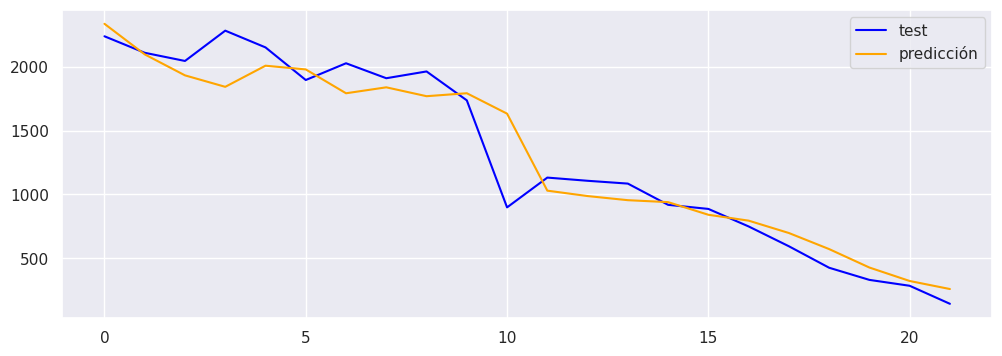

In [17]:
# Predicciones en la escala original
y_test_inv = scaler.inverse_transform(Y_test)

y_pred_inv = y_pred.reshape(-1,1)
y_pred_inv = scaler.inverse_transform(y_pred_inv)

plt.figure(figsize=(12,4))
plt.plot(y_test_inv[0:500],color='blue',label='test')
plt.plot(y_pred_inv[0:500],color='orange',label='predicción')
plt.legend();

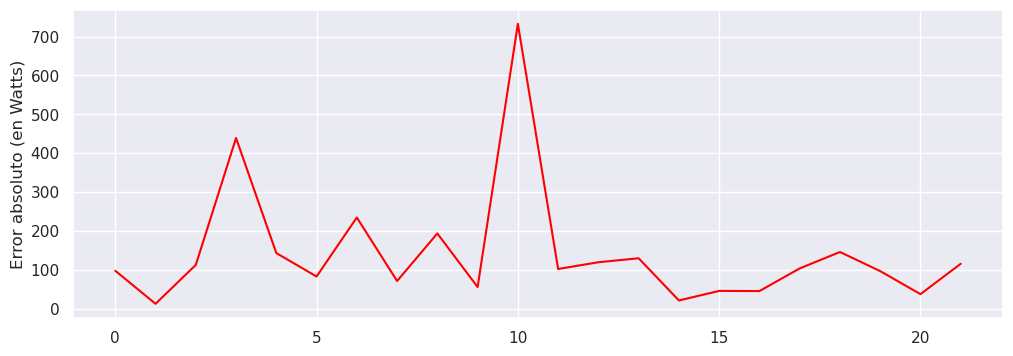

In [18]:
# Gráfica del error absoluto
plt.figure(figsize=(12,4))
plt.plot(np.abs(y_test_inv-y_pred_inv), color='red');
plt.ylabel('Error absoluto (en Watts)');

In [19]:
modelo.save('modeloLSTM5.h5')  # Guarda el modelo en formato HDF5

/usr/lib/python3/dist-packages/keras/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Ahora haremos predicción *multi-step*: en lugar de predecir un sólo dato vamos a predecir una secuencia completa:

In [20]:
# Tomar la primera parte de X_test como punto de inicio
x_pred = X_test[0,:,:].reshape(1,LONG_SEC,1)

# Iterativamente predecir y201 = pred(x1,x2,...,x200),
# y202 = pred(x2, x3, x4,..., x200, y201), etc...

N_preds = 100
y_preds = []    

for i in range(N_preds):

  pred = modelo.predict(x_pred)
  y_preds.append(pred[0])

  x_pred = np.append(x_pred,pred[0])

  x_pred = np.delete(x_pred,0)

  x_pred = np.reshape(x_pred,(1,LONG_SEC,1))

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


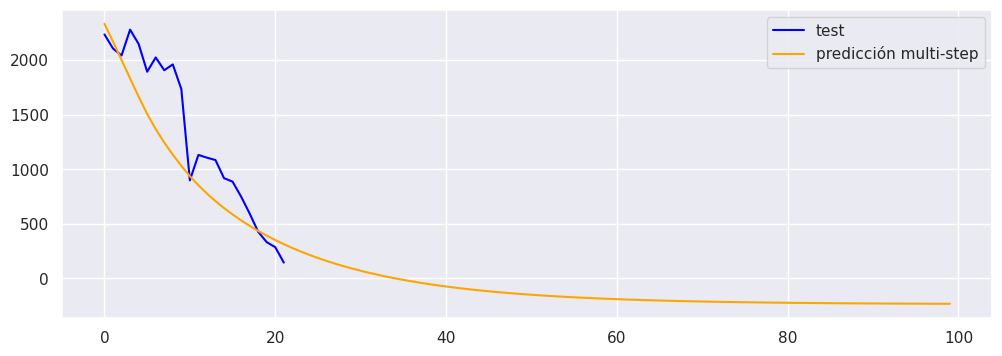

In [21]:
# Regresamos las predicciones en la escala original
y_preds = np.array(y_preds).reshape(-1,1)
y_preds = scaler.inverse_transform(y_preds)

# Comparación gráfica con el set de prueba original
plt.figure(figsize=(12,4))
plt.plot(y_test_inv[0:N_preds],color='blue',label='test')
plt.plot(y_preds[0:N_preds],color='orange',label='predicción multi-step')
plt.legend();

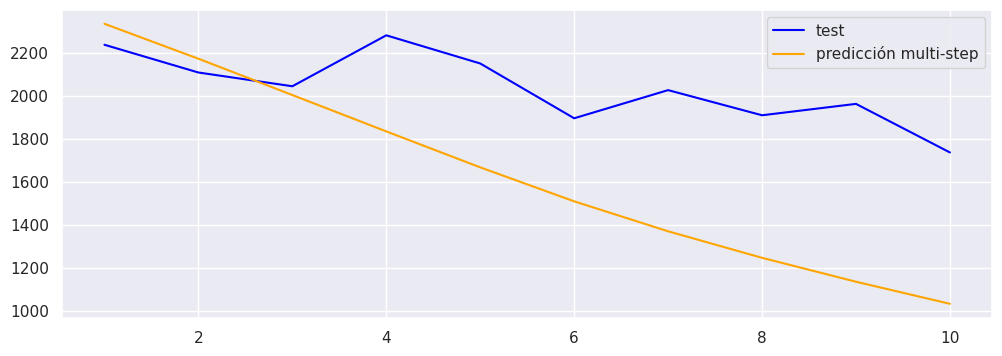

In [22]:
HRS = 10
plt.figure(figsize=(12,4))
plt.plot(range(1,HRS+1),y_test_inv[0:HRS],color='blue',label='test')
plt.plot(range(1,HRS+1),y_preds[0:HRS],color='orange',label='predicción multi-step')
plt.legend();